# Sehgal Radio Sources

Implementing new models like radio sources in the `xgpaint.jl` framework is trivial (I hope). Actually, it'll be really interesting to see what parts of are shared between CIB and radio. This will inform the architecture of the final code package.

# 1. Read a Catalog

We operate with HDF5. I convert the `.pksc` format into `.hdf5` in the `pksc2hdf5.py` script (needs some work).

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
using HDF5
using SharedArrays
using Healpix
using PoissonRandom
using Distributions
using Interpolations
using QuadGK
using Base.GC
using Roots
using Cosmology
using Unitful
using UnitfulAstro
using Random

In [3]:
const NPROCS = 20

using Distributed
addprocs(NPROCS);

In [4]:
@everywhere begin
    using HDF5
    using SharedArrays
    using Healpix
    using PoissonRandom
    using Distributions
    using Interpolations
    using QuadGK
    using Base.GC
    using Roots
    using Cosmology
    using Unitful
    using UnitfulAstro
    using Random
    # set different seeds for worker IDs
    Random.seed!(myid() + trunc(Int64, time()))
end

The radio sources do not have "centrals" or "satellites". They just live in the halos. Hence, we are storing instead `halo_n_I` and `halo_n_II`, the halo occupation numbers.

In [6]:
f = open("/tigress/zequnl/xgpaint/halo_nbody.binary")
buffer = Array{Float32}(undef,20,1414339)
read!(f, buffer )

f = open("/tigress/zequnl/xgpaint/halo_low_mass.binary")
buffer2 = Array{Float32}(undef,20,6431049)
read!(f, buffer2 )

buffer = hcat( (buffer, buffer2)... )
buffer = buffer[ :, buffer[11,:] .> 1e13 ]

20×5280748 Array{Float32,2}:
    0.003916       0.008981       0.01102     …     3.037          3.03702   
   60.5925        35.1962        21.7048           28.9205        25.0936    
   23.8934         1.45353        2.14709          59.1569        51.2592    
    7.34686       30.8015        43.0376         2934.46        3705.98      
   13.0346        21.725         17.1309         1621.28        1735.5       
    6.6284         0.956416       1.73667     …  5614.36        5100.47      
 -162.619       -231.761       -140.053          -389.417       -505.656     
  192.061         -9.09485       28.2308          139.267         77.9243    
 -208.2         -327.008       -205.712            21.298        279.957     
    2.94109e13     2.9507e13      5.12288e13        1.29754e13     1.40327e13
    2.42207e13     2.63353e13     4.5462e13   …     1.14376e13     1.32637e13
    0.756536       0.776184       0.927612          0.193139       0.200279  
    1.59549e13     2.02801e13     3

In [114]:
@time begin

    N_halos = size(buffer,2)
    
    halo_x_pos = SharedArray{Float32}(N_halos)
    halo_y_pos = SharedArray{Float32}(N_halos)
    halo_z_pos = SharedArray{Float32}(N_halos)
    halo_mass = SharedArray{Float32}(N_halos)
    
    # fill up known quantities
    halo_x_pos .= buffer[4,:]
    halo_y_pos .= buffer[5,:]
    halo_z_pos .= buffer[6,:]
    halo_mass .= buffer[11,:]
    @everywhere GC.gc()
    
    # derived parameters
    halo_comoving_dist = SharedArray{Float32}(N_halos)
    halo_redshift = SharedArray{Float32}(N_halos)
    
    halo_redshift .= buffer[1,:]
    
    halo_n_I = SharedArray{Int32}(N_halos)
    halo_n_II = SharedArray{Int32}(N_halos)
end;

  0.904331 seconds (636.63 k allocations: 134.129 MiB, 21.33% gc time)


We specify the parameters here. We're taking the model parameters straight from Table 2 of Sehgal et al. 2009.

![pasted image](data/table.png)

In [13]:
@everywhere begin
    # sehgal model parameters
    
    # these coefficients are shared for type I and II
    const a_0   = 0.0
    const a_1_dist = Uniform(-0.12,  0.07)
    const a_2_dist = Uniform(-0.34,  0.99)
    const a_3_dist = Uniform(-0.75, -0.23)
    
    const I_R_int = 10^(-2.6)
    const I_γ = 6.0
    const I_N_0 = 1.0
    const I_M_0 = 4e13
    const I_α = 0.1
    const I_L_b = 10^(24.0)
    const I_m = -1.55
    const I_n = 0.0
    const I_δ = 3.0
    const I_z_p = 0.8
    
    const II_R_int = 10^(-2.8)
    const II_γ = 8.0
    const II_N_0 = 0.015
    const II_M_0 = 3e15
    const II_α = 0.1
    const II_L_b = 10^(27.5)
    const II_m = -1.6
    const II_n = -0.65
    const II_z_p = 1.3
    const II_σ_l = 0.4
    const II_σ_h = 0.73
    
    
    # output
    const nside   = 4096
    
    # physical constants
    const phys_h     = 6.62606957e-27   # erg.s
    const phys_c     = 3e+10            # cm/s
    const phys_k     = 1.3806488e-16    # erg/K
    const phys_Msun  = 2e33             # g
    const phys_Mpc   = 3.086e24         # cm
    
    # cosmology
    const omegab  = 0.044
    const omegac  = 0.22
    const omegam  = omegab + omegac
    const h = 0.71
    const rhocrit = 2.78e11 * omegam * (h^2)
    
    const jl_cosmo = cosmology(h=h, OmegaM=omegam)
end

In [14]:
@everywhere function build_r2z_interpolator()
    """
    Construct a fast r2z linear interpolator.
    """
    zrange = LinRange(0.0, 6.0, 1000)
    rrange = [ustrip(comoving_radial_dist(u"Mpc", jl_cosmo, z))
        for z in zrange];
    r2z = LinearInterpolation(rrange, zrange);
    return r2z
end

@everywhere const r2z = build_r2z_interpolator();

      From worker 6:	WARNING: redefining constant r2z
      From worker 14:	WARNING: redefining constant r2z
      From worker 18:	WARNING: redefining constant r2z
      From worker 20:	WARNING: redefining constant r2z
      From worker 7:	WARNING: redefining constant r2z
      From worker 5:	WARNING: redefining constant r2z
      From worker 9:	WARNING: redefining constant r2z
      From worker 12:	WARNING: redefining constant r2z
      From worker 16:	WARNING: redefining constant r2z
      From worker 21:	WARNING: redefining constant r2z
      From worker 19:	WARNING: redefining constant r2z
      From worker 13:	WARNING: redefining constant r2z
      From worker 4:	WARNING: redefining constant r2z
      From worker 2:	WARNING: redefining constant r2z
      From worker 10:	WARNING: redefining constant r2z
      From worker 17:	WARNING: redefining constant r2z
      From worker 15:	WARNING: redefining constant r2z
      From worker 11:	WARNING: redefining constant r2z
      From worke

In [16]:
function fill_halovars!(
        x, y, z, # inputs
        redshift_result, dist_result) # outputs
    """
    This function computes distance and redshift in parallel.
    """
    
    N_halos = size(x,1)
    @sync @distributed for i = 1:N_halos
        dist_result[i] = sqrt(x[i]^2 + y[i]^2 + z[i]^2)
        redshift_result[i] = r2z(dist_result[i])
    end
end

fill_halovars! (generic function with 1 method)

We compute the comoving distance, spherical coordinates, and redshift of the halos and store them in the shared memory array `halo_derived`. It's in parallel, so it takes just seconds!

In [17]:
@time fill_halovars!(halo_x_pos, halo_y_pos, halo_z_pos,
    halo_redshift, halo_comoving_dist)

  1.873096 seconds (2.59 M allocations: 133.729 MiB, 2.15% gc time)


Task (done) @0x00002b0186c1f820

In [18]:
@everywhere GC.gc()

# 2. HOD
We assign a number of satellites to each halo. Sehgal assumes the halo occupation number (HON) is given by
$$ N(M) = N_0 (M / M_0)^{\alpha}.$$

In [19]:
@everywhere begin
    pdf_norm1(x, μ, σ) = exp( -(x-μ)^2 / (2 * σ^2) );

    function FR_I_redshift_evolution(z)
        if z < I_z_p
            return (1+z)^I_δ
        else
            return (1+I_z_p)^I_δ
        end
    end

    function FR_II_redshift_evolution(z)
        norm = pdf_norm1(0, II_z_p, II_σ_l)
        if z < II_z_p
            return pdf_norm1(z, II_z_p, II_σ_l) / norm
        else
            return pdf_norm1(z, II_z_p, II_σ_h) / norm
        end
    end
end

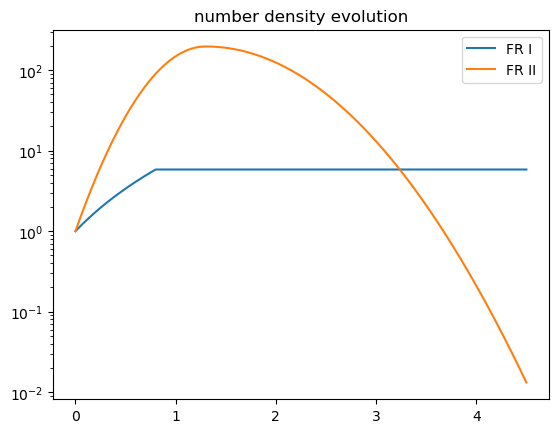

PyObject <matplotlib.legend.Legend object at 0x2b017fd80f50>

In [20]:
zt = LinRange(0.0, 4.5, 1000)

plot(zt, FR_I_redshift_evolution.(zt), label="FR I")
plot(zt, FR_II_redshift_evolution.(zt), label="FR II")

yscale("log")
title("number density evolution")
legend()

In [21]:
function hod_sehgal(n_I_result, n_II_result,
        halo_mass::SharedArray, z::SharedArray)
    # computes sehgal HOD and generates a Poisson draw
    N_halos = size(halo_mass,1)
    
    @sync @distributed for i = 1:N_halos
        I_HON = I_N_0 * (halo_mass[i] / I_M_0)^I_α 
        I_HON *= FR_I_redshift_evolution(z[i])
        n_I_result[i] = pois_rand(convert(Float64, I_HON))
        
        II_HON = II_N_0 * (halo_mass[i] / II_M_0)^II_α
        II_HON *= FR_II_redshift_evolution(z[i])
        n_II_result[i] = pois_rand(convert(Float64, II_HON))
    end
    
end

hod_sehgal (generic function with 1 method)

In [22]:
@time hod_sehgal(halo_n_I, halo_n_II, halo_mass, halo_redshift)

  0.573318 seconds (447.01 k allocations: 23.247 MiB, 1.18% gc time)


Task (done) @0x00002b01865d5d50

In [23]:
println( sum(halo_n_I[halo_redshift .< 0.3]), ", ",
    sum(halo_n_II[halo_redshift .< 0.3]) )

234210, 6791


# 3. Halos to Sources to Maps

This is a loop *for each halo*, which does the following.

```
for loop over $n_{halo}$
    for loop over $n_{sat}$ of the halo
        do tasks
```

### Tasks
1. draw a random source
2. assign it a luminosity 
3. convert that luminosity to a flux
4. map to a healpix pixel index and add that flux

The Sehgal LF is

$$ p(L) = \begin{cases}   (L/L_b)^m &  L > L_b \\  (L/L_b)^n & \mathrm{otherwise} \end{cases} $$

In [24]:
@everywhere begin
    function sehgal_LFn0(m, Lb; Lmin=1e22)
        crossover = log( Lb/Lmin )
        x = rand() * (-(1/m)+log(Lb/Lmin))
        if x < crossover
            return exp(x) * Lmin
        else
            return Lb * (1+m * x + m * log(Lmin/Lb))^(1/m)
        end
    end
    
    function sehgal_LF(m, n, Lb; Lmin=1e22)
        if n == 0.0
            return sehgal_LFn0(m, Lb; Lmin=Lmin)
        end
        crossover = (1.0 - Lb^-n * Lmin^n)/n
        x = rand() * (m-Lb^(-n) * Lmin^n * m-n)/(m * n)
        if x < crossover
            return (Lmin^n + Lb^n * n * x)^(1/n)
        else
            return Lb * (1.0 + (m * (-1.0 + (Lmin/Lb)^n + n * x))/n)^(1.0/m)
        end
    end
end

In [25]:
sehgal_LF(II_m, II_n, II_L_b)

8.602571442150386e23

In [26]:
sehgal_LF(I_m, I_n, I_L_b)

1.020822709235399e23

In [27]:
using DelimitedFiles

In [28]:
sehgal_red = readdlm("data/sehgal_figure8_red.txt", ',', Float64, '\n')
sehgal_blue = readdlm("data/sehgal_figure8_blue.txt", ',', Float64, '\n')
sehgal_green = readdlm("data/sehgal_figure8_green.txt", ',', Float64, '\n')

5×2 Array{Float64,2}:
 1.89183e25  8.58366e-6 
 5.94557e25  1.11558e-6 
 1.89769e26  8.05405e-8 
 5.964e26    2.83443e-8 
 5.98249e27  8.47917e-10

In [29]:
using CSVFiles, DataFrames

We have a physical measured flux. We need to get the intrinsic luminosity, given the redshift.

In [30]:
raw_3crr = DataFrame(load(File(format"CSV", "data/3crr.dat"), spacedelim=true, header_exists=true));
raw_3crr[1:3,:]

,3CRR_name,IAU_name,Redshift,Flux178MHz_Jy,Sp_index,FR_class,Flux5GHzcore_mJy
,String,String,Float64,Float64,Float64,Int64,String
1,4C12.03,0007+124,0.156,10.9,0.87,2,3.5
2,3C6.1,0013+790,0.8404,14.9,0.68,2,4.4
3,3C9,0017+154,2.012,19.4,1.12,2,4.9


Recall that the differential flux $S_{\nu}$ is related to the differential luminosity $L_{\nu} \, [W/Hz]$, by

$$ S_{\nu} = \frac{L_{(1+z)\nu} }{4 \pi (1+z) D_M^2} .$$

We know the differential flux, as well as the redshift, so we can solve for the intrinsic luminosity. However this means we have to solve for the comoving distance with respect to redshift.

In [31]:
function Lum(ν, S₀, ν₀, z, α)
    DM = comoving_radial_dist(jl_cosmo, z)
    return uconvert( u"W/Hz", 
        4π * S₀ * (ν/ν₀)^(-α) * (1+z)^(1+α) * DM^2
    )
end

Lum (generic function with 1 method)

In [32]:
raw_3crr[1:4,:Flux178MHz_Jy]
L_3CRR = Lum.( 151.0u"MHz", raw_3crr[!,:Flux178MHz_Jy]u"Jy", 178u"MHz", raw_3crr[!,:Redshift], raw_3crr[!,:Sp_index] );

lowz = (raw_3crr[!,:Redshift] .< 0.3)
FRI_samp = ustrip.( u"W/Hz", L_3CRR[ (raw_3crr[!,:FR_class] .== 1) .& lowz ] )
FRII_samp = ustrip.( u"W/Hz", L_3CRR[ (raw_3crr[!,:FR_class] .== 2) .& lowz ] );

In [33]:
perV = 1.0 / ustrip( u"Mpc^3", comoving_volume(jl_cosmo, 0.3) )

1.4277098122617298e-10

In [34]:
"""
Get bin index. Optimized for declining distributions where 
the smaller bin values are more common than the larger bins.
"""

@everywhere function bin_ind(x::T, bin_left_edges::AbstractArray{T,1}) where {T}
    if x < bin_left_edges[1]
        return 1
    end
    for i in 1:length(bin_left_edges)
        if bin_left_edges[i] > x
            return i-1
        end
    end
    return length(bin_left_edges)
end

function bin_vec(vec, bins)
    counter = zeros(Int64, length(bins))
    
    for v in vec
        counter[bin_ind(v, bins)] += 1
    end
    
    return counter
end

bin_vec (generic function with 1 method)

In [35]:
bins = (range(23.9, stop=29.1, step=0.5));

In [36]:
function plot_bins(binlefts, counts)
    xs = vcat(  [[binlefts[i], binlefts[i+1]] for i in 1:(length(binlefts)-1)]... )
    ys = vcat(  [[counts[i], counts[i]] for i in 1:(length(binlefts)-1)]... )
    return xs, ys
end

plot_bins (generic function with 1 method)

# Reproducing the 151 MHz RLF for $z \leq 3$

In [96]:
function make_RLF(n_I, n_II, mass, redshift, counter, bins)
    
    counter .= 0
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
#         ν_Hz = (1+redshift[i]) .* ν_obs_arr
        if redshift[i] < 0.3

            # do it for FR_I
            for j = 1:n_I[i]
                L = sehgal_LF(I_m, I_n, I_L_b; Lmin=3e23)
                ind = bin_ind(log10.(L), bins)
                if ind > 0
                    counter[ind] += 1
                end
            end

            # do it for FR_II
            for j = 1:n_II[i]
                L = sehgal_LF(II_m, II_n, II_L_b; Lmin=5e23)
                ind = bin_ind(log10.(L), bins)
                if ind > 0
                    counter[ind] += 1
                end
            end
        end
        
    end
end

make_RLF (generic function with 1 method)

In [97]:
bins = (range(23.9, stop=29.1, step=0.1));
counter = SharedArray{Int64}(length(bins));
make_RLF(halo_n_I, halo_n_II, halo_mass, halo_redshift, counter, bins)

Task (done) @0x00002b014a8c09d0

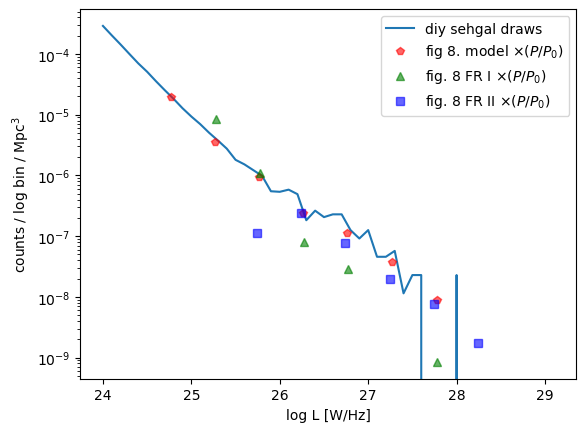

PyObject <matplotlib.legend.Legend object at 0x2b01c80bd690>

In [98]:
vol = ustrip(u"Mpc^3",comoving_volume( jl_cosmo, 0.3)) / 8.0
plot(bins[2:end], counter[2:end] ./ diff((bins)) ./ vol , label="diy sehgal draws" )

ylabel("counts / log bin / Mpc\$^3\$")
xlabel("log L [W/Hz]")
yscale("log")


plot( log10.(sehgal_red[:,1]), sehgal_red[:,2] , "rp", label="fig 8. model \$\\times (P/P_0)\$", alpha=0.6)
plot( log10.(sehgal_green[:,1]), sehgal_green[:,2] , color="green", "^", label="fig. 8 FR I \$\\times (P/P_0)\$", alpha=0.6)
plot( log10.(sehgal_blue[:,1]), sehgal_blue[:,2] , color="blue", "s", label="fig. 8 FR II \$\\times (P/P_0)\$", alpha=0.6)


# plot( bins[2:end], 1e23 .* (10 .^bins[2:end]) .^ -1 )
legend()
# ylim(2e-10, 9e-5)
# xticks(10.0 .^ collect(24:29))

## Lobe/Core and Spectral Shape

We draw a luminosity $L_{beam}$ from $p(L)$ described above. Then we can divide this into two separate components, 

$$ L_{\mathrm{beam}} = L_{c,\mathrm{beam}} + L_{l,\mathrm{int}} . $$

The core-to-lobe flux ratio $R_{\mathrm{obs}} \equiv L_{c,\mathrm{beam}}/L_{l,\mathrm{int}}$ is also randomly generated. We assume a uniform distribution of $\cos \theta$, the angle between the line-of-sight and the jet axis. The inputs here are

1. our random $L_{\mathrm{beam}}$ draw from $p(L)$
2. fixed $R_{\mathrm{int}}$ and $\gamma$ from Wilman et al. 2008 [W08] 
3. a random draw of $\cos \theta \in [0,1]$.

We can then calculate the ratio

$$ R_{\mathrm{obs}} = R_{\mathrm{int}} B(\theta) \quad \quad \beta = \sqrt{1-\gamma^{-2}} $$
$$ B(\theta) = [ (1-\beta \cos \theta)^{-2} + (1 + \beta \cos \theta)^{-2} ] / 2.$$

Now you have the observed ratios, you can write 

$$ L_{c,\mathrm{beam}} = \frac{ R_{\mathrm{obs}} L_{\mathrm{beam}} }{ 1 + R_{\mathrm{obs}} }, \quad \quad L_{l,\mathrm{int}} = \frac{ L_{\mathrm{beam}} }{1 + R_{\mathrm{obs}}}.$$

Each component has its own spectral shape. For $a_i$ drawn from uniform distributions (see table) for each source,

$$ \log f_{\mathrm{core}}(\nu) = \sum_{i=0}^3 a_i \left(\log \frac{\nu}{151 \, \mathrm{MHz}} \right)^i , $$
$$ f_{\mathrm{lobe}}(\nu) = \left( \frac{\nu}{151 \, \mathrm{MHz}} \right)^{-0.8}.$$

We normalize both spectral shapes such that $ f(151 \, \mathrm{MHz}) = 1$ because I'm assuming $p(L)$ is describing the $z \sim 0$, 151 MHz RLF.

In [99]:
@everywhere begin
    B(cosθ, β) = ( (1-β*cosθ)^(-2) + (1+β*cosθ)^(-2) ) / 2.0

    function get_core_lobe_lum(L, ν_Hz, R_int, γ, a_1, a_2, a_3)
        β = sqrt(1-γ^(-2))
        cosθ = rand()
        R_obs = R_int * B(cosθ, β)

        # compute how the luminosity is split up
        L_c = R_obs * L / (1 + R_obs)
        L_l = L / (1 + R_obs)

        # now put in the frequency dependence. a_0 = 0.0
        lν = log10(ν_Hz / 1e9 ) # normed to 151 MHz
        f_core =  10 ^ ( a_1 * lν + a_2 * lν^2 + a_3 * lν^3 )
        
        
        lν_norm = log10(151e6 / 1e9 ) # normed to 151 MHz
        norm_core =  10 ^ ( a_1 * lν_norm + a_2 * lν_norm^2 + a_3 * lν_norm^3 )
        f_lobe = (ν_Hz / 151e6 ).^(-0.8)
        
        return L_c * f_core / norm_core, L_l * f_lobe
    end
end

In [100]:
@everywhere function l2f(Lum, r_comoving, redshift)
    return Lum / (4π * r_comoving^2 * (1.0 + redshift))
end

In [101]:
bins = (range(-4, stop=2, step=0.1));
counter = SharedArray{Int64}(length(bins));

In [102]:
function make_source_counts(ν_Hz, d_cm, n_I, n_II, mass, redshift, counter, bins; corefac=1.0, lobefac=1.0)
    
    flux_to_Jy = ustrip(u"Jy", 1u"W/Hz*Mpc^-2")
    
    counter .= 0
    # @sync @distributed  
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
        ν_lum = (1+redshift[i]) .* ν_Hz
        if redshift[i] < 10.0

            # do it for FR_I
            for j = 1:n_I[i]
                L = sehgal_LF(I_m, I_n, I_L_b; Lmin=1e24)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                L_c, L_l = get_core_lobe_lum(L, ν_lum, I_R_int, I_γ,
                    a_1, a_2, a_3)
                flux = l2f(L_c*corefac+L_l*lobefac, d_cm[i], redshift[i]) * flux_to_Jy
                ind = bin_ind(log10.(flux), bins)
                if ind > 1
                    counter[ind] += 1
                end
            end

            # do it for FR_II
            for j = 1:n_II[i]
                L = sehgal_LF(II_m, II_n, II_L_b; Lmin=1e24)
                a_1 = rand(a_1_dist)
                a_2 = rand(a_2_dist)
                a_3 = rand(a_3_dist)
                L_c, L_l = get_core_lobe_lum(L, ν_lum, II_R_int, II_γ,
                    a_1, a_2, a_3)
                flux = l2f(L_c*corefac+L_l*lobefac, d_cm[i], redshift[i]) * flux_to_Jy
                ind = bin_ind(log10.(flux), bins)
                if ind > 1
                    counter[ind] += 1
                end
            end
            
        end
        
    end
end

make_source_counts (generic function with 1 method)

In [103]:
@time make_source_counts(1.4e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counter, bins)

  1.593663 seconds (263.19 k allocations: 14.268 MiB, 0.79% gc time)


Task (done) @0x00002b0187b7b0d0

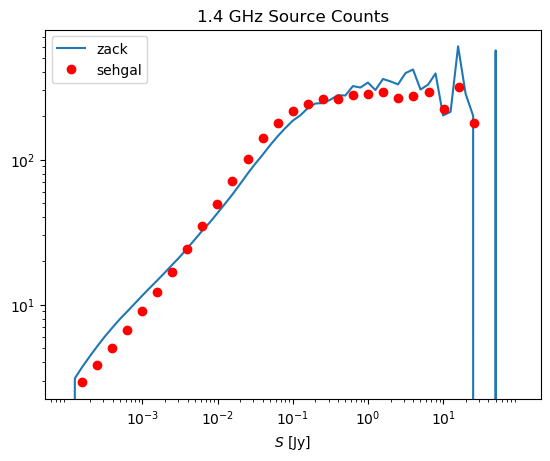

PyObject Text(0.5, 1, '1.4 GHz Source Counts')

In [104]:
plot(10 .^ bins, counter .* (10 .^ bins).^1.5 ./ diff(bins)[1] ./ (4π/8) / 4, label="zack" )

Sehgal1_4GHz = readdlm("data/sehgal_fig9_1.4GHz.txt", ',', Float64, '\n');
plot(Sehgal1_4GHz[:,1], Sehgal1_4GHz[:,2], "ro", label="sehgal")

# wilman_151 = readdlm("data/wilman_151.txt", ',', Float64, '\n');
# plot(wilman_151[:,1] ./ 1e3, wilman_151[:,2], "ro", label="sehgal")

yscale("log")
xscale("log")
xlabel("\$ S \$ [Jy]")
xticks(10 .^ [-3.,-2.,-1.,0.,1.])
legend()

title("1.4 GHz Source Counts")

In [105]:
bins = (range(-4, stop=2, step=0.1));
counter = SharedArray{Int64}(length(bins));
@time make_source_counts(145e9, halo_comoving_dist, halo_n_I, halo_n_II, 
    halo_mass, halo_redshift, counter, bins)

  1.385508 seconds (9.41 k allocations: 568.969 KiB)


Task (done) @0x00002b01878d4760

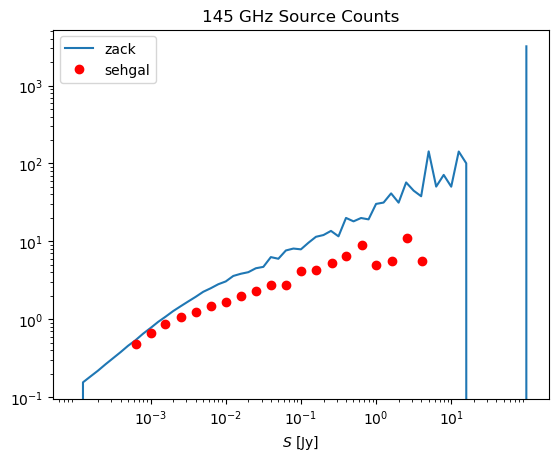

PyObject Text(0.5, 1, '145 GHz Source Counts')

In [106]:
plot(10 .^ bins, counter .* (10 .^ bins).^1.5 ./ diff(bins)[1] ./ (4π/8) / 4, label="zack" )

Sehgal1_4GHz = readdlm("data/sehgal_fig9_145GHz.txt", ',', Float64, '\n');
plot(Sehgal1_4GHz[:,1], Sehgal1_4GHz[:,2], "ro", label="sehgal")

# wilman_151 = readdlm("data/wilman_151.txt", ',', Float64, '\n');
# plot(wilman_151[:,1] ./ 1e3, wilman_151[:,2], "ro", label="sehgal")

yscale("log")
xscale("log")
xlabel("\$ S \$ [Jy]")
xticks(10 .^ [-3.,-2.,-1.,0.,1.])
legend()

title("145 GHz Source Counts")

In [107]:
sehgal_radio_cat = DataFrame(load(File(format"CSV", "/tigress/zequnl/xgpaint/radio.cat"), 
        spacedelim=true, header_exists=false, colnames=["ra","dec","z","f_1_4","f_30","f_90", "f_148","f_219","f_277","f_350"]));

In [115]:
function get_least_massive(catz, otherz, masses)
    best_mass = 1e20
    for z in catz
        best_i = argmin( abs.(z .- otherz) )
        if best_mass > masses[best_i]
            best_mass = masses[best_i]
        end
    end
    return best_mass
end

get_least_massive (generic function with 1 method)

In [ ]:
get_least_massive( sehgal_radio_cat.z, halo_redshift, halo_mass )

In [108]:
bins = (range(-4, stop=2, step=0.1));
counter_sehgal = SharedArray{Int64}(length(bins));

for i in 1:length(sehgal_radio_cat[!,:f_1_4])
    ind = bin_ind(log10(sehgal_radio_cat[i,:f_1_4]) - 3.0, bins)
    if ind > 1
        counter_sehgal[ind] += 1
    end
end


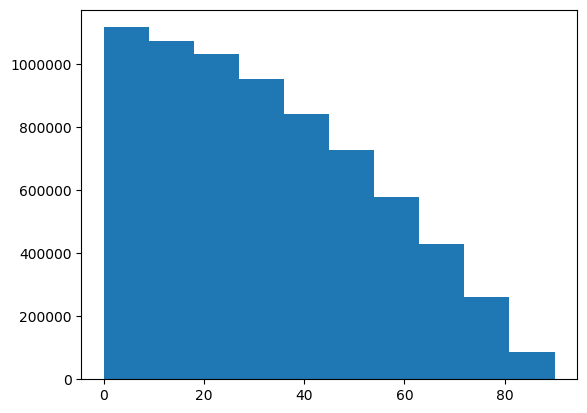

([1.11811e6, 1.074301e6, 1.033613e6, 953425.0, 842833.0, 726921.0, 580562.0, 428487.0, 262684.0, 87215.0], [-0.030632, 8.969272499999999, 17.969177, 26.969081499999998, 35.968986, 44.9688905, 53.968795, 62.9686995, 71.968604, 80.9685085, 89.968413], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb73590>, PyObject <matplotlib.patches.Rectangle object at 0x2b01d33dcc50>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb73c90>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb73110>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb71890>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb71110>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb715d0>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb76750>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb710d0>, PyObject <matplotlib.patches.Rectangle object at 0x2b01ccb71390>])

In [113]:
hist(sehgal_radio_cat.dec)

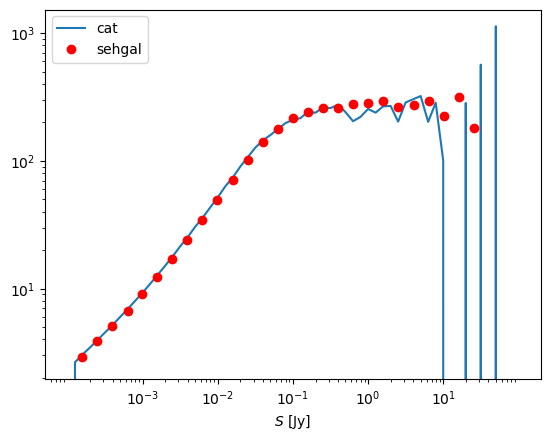

PyObject <matplotlib.legend.Legend object at 0x2b01c55e2c50>

In [109]:
plot(10 .^ bins, counter_sehgal .* (10 .^ bins).^1.5 ./ diff(bins)[1] ./ (4π/8) / 2, label="cat" )
Sehgal1_4GHz = readdlm("data/sehgal_fig9_1.4GHz.txt", ',', Float64, '\n');
plot(Sehgal1_4GHz[:,1], Sehgal1_4GHz[:,2], "ro", label="sehgal")


yscale("log")
xscale("log")
xlabel("\$ S \$ [Jy]")
xticks(10 .^ [-3.,-2.,-1.,0.,1.])
legend()

In [62]:
@everywhere const Healpix_res = Resolution(nside)

In [63]:
function make_map(x, y, z, d_cm, redshift, 
        n_I, n_II, ν_obs_arr,
        
        debug_mode=false, I_ind=nothing, II_ind=nothing,
        L_I=nothing, L_II=nothing, z_I=nothing, z_II=nothing
    )
    """Generate a CIB map given a HOD.
    
    Frequency ν_obs must be in Hz.
    """
    N_halos = size(d_cm,1)
    N_freqs = size(ν_obs_arr,1)
    result_map = SharedArray{Float64}((N_freqs,Healpix.nside2npix(nside))); 
    result_map .= 0.0 # initialize to zero
    
    @sync @distributed  for i = 1:N_halos
        
        # all sources are smack on the halo
        ν_Hz = (1+redshift[i]) .* ν_obs_arr
        hp_index = Healpix.vec2pixRing(Healpix_res, x[i], y[i], z[i])
        
        # do it for FR_I
        for j = 1:n_I[i]
            L = sehgal_LF(I_m, I_n, I_L_b)
            a_1 = rand(a_1_dist)
            a_2 = rand(a_2_dist)
            a_3 = rand(a_3_dist)
            for ν_i in 1:N_freqs
                L_c, L_l = get_core_lobe_lum(L, ν_Hz[ν_i], I_R_int, I_γ,
                    a_1, a_2, a_3)
                flux = l2f(L_c + L_l, d_cm[i], redshift[i])
                result_map[ν_i, hp_index] += flux
            end
            
            if debug_mode
                L_I[I_ind[i] + j] = flux
                z_I[I_ind[i] + j] = redshift[i]
            end
        end
        
        # do it for FR_II
        for j = 1:n_II[i]
            L = sehgal_LF(II_m, II_n, II_L_b)
            a_1 = rand(a_1_dist)
            a_2 = rand(a_2_dist)
            a_3 = rand(a_3_dist)
            
            for ν_i in 1:N_freqs
                L_c, L_l = get_core_lobe_lum(L, ν_Hz[ν_i], II_R_int, II_γ, 
                    a_1, a_2, a_3)
                flux = l2f(L_c + L_l, d_cm[i], redshift[i])
                result_map[ν_i, hp_index] += flux
            end
            
            if debug_mode
                L_II[II_ind[i] + j] = flux
                z_II[II_ind[i] + j] = redshift[i]
            end
        end
        
    end
    
    meters_per_mpc = 3.086e+22
    pix_area = Healpix.nside2pixarea(nside) * meters_per_mpc^2
    return result_map ./ pix_area 
end

make_map (generic function with 8 methods)

In [65]:
# freq_list = [30, 90, 148, 219, 277, 350 ] .* 1e9;
freq_list = [1.4] .* 1e9;

In [66]:
@time result = make_map(
    halo_x_pos, halo_y_pos, halo_z_pos, 
    halo_comoving_dist, halo_redshift,
    halo_n_I, halo_n_II, freq_list
);

158.676217 seconds (2.46 M allocations: 4.623 GiB, 0.07% gc time)


In [67]:
m = Map{Float64, RingOrder}(nside)
for i in 1:size(freq_list,1)
    filename = "/tigress/zequnl/xgpaint/radio_wilman_$(freq_list[i]/1e9).fits"
    try
        run(`rm $filename`)
    catch err
        println(err)
    end
    m.pixels .= result[i,:];
    Healpix.saveToFITS(m, filename)
end

rm: cannot remove ‘/tigress/zequnl/xgpaint/radio_wilman_48.0.fits’: No such file or directory


ErrorException("failed process: Process(`rm /tigress/zequnl/xgpaint/radio_wilman_48.0.fits`, ProcessExited(1)) [1]")


In [19]:
# @time begin
#     halo_I_ind = SharedArray{Int64}(N_halos)
#     halo_II_ind = SharedArray{Int64}(N_halos)
    
#     function gen_ind(I_ind, II_ind)
#         cI = 0
#         cII = 0
#         for i in 1:N_halos
#             I_ind[i] = cI
#             cI += halo_n_I[i]
#             II_ind[i] = cII
#             cII += halo_n_II[i]
#         end
#     end
    
#     gen_ind(halo_I_ind, halo_II_ind)
# end

In [20]:
# halo_L_I = SharedArray{Float32}(sum(halo_n_I)); 
# halo_L_II = SharedArray{Float32}(sum(halo_n_II)); 
# halo_z_I = SharedArray{Float32}(sum(halo_n_I)); 
# halo_z_II = SharedArray{Float32}(sum(halo_n_II)); 

# @time result = make_map(
#     halo_x_pos, halo_y_pos, halo_z_pos, 
#     halo_comoving_dist, halo_redshift,
#     halo_n_I, halo_n_II, 100e9,
    
#     true, halo_I_ind, halo_II_ind, halo_L_I, halo_L_II, halo_z_I, halo_z_II
# );

In [23]:
# using Plots
# gr()  # Use the GR backend

# logm = Map{Float64, RingOrder}(nside)
# logm.pixels .= log10.(result);
# Plots.plot( logm )

In [57]:
# m = Map{Float64, RingOrder}(nside)
# m.pixels .= result[1,:];
# Healpix.saveToFITS(m, "/tigress/zequnl/xgpaint/radio100.fits")